In [ ]:
# !pip install datasets sentence-transformers chromadb

In [33]:
import requests
import numpy as np
import pandas as pd
from PIL import Image
from datasets import load_dataset
from transformers import CLIPProcessor, CLIPModel

ds = load_dataset("ashraq/fashion-product-images-small")
df = pd.DataFrame(ds['train'])
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

In [54]:
def extract_features(row):
    image = row['image']
    image_inputs = processor(images=image, return_tensors="pt", padding=True)
    img_features = model.get_image_features(**image_inputs).detach().numpy()
    img_features = img_features / np.linalg.norm(img_features)
    return img_features

def extract_text_features(text):
  text_inputs = processor(text=[text], return_tensors="pt", padding=True)
  text_features = model.get_text_features(**text_inputs).detach().numpy()
  text_features = text_features / np.linalg.norm(text_features)
  return text_features

In [36]:
df = df[:4000]
embeddings = [feature[0].tolist() for feature in df.apply(extract_features, axis=1)]
metadatas = [{'product_name':i} for i in df.productDisplayName]
ids = [str(i) for i in list(df.id)]

In [37]:
import chromadb

client = chromadb.Client()
collection = client.create_collection("products")

collection.add(
    embeddings=embeddings,
    metadatas=metadatas,
    ids=ids
)

In [48]:
import matplotlib.pyplot as plt

def plot_results(results, df):
    num_images = len(results['ids'][0])
    max_columns = 3
    columns = min(max_columns, num_images)
    rows = (num_images + columns - 1) // columns

    plt.figure(figsize=(columns * 3, rows * 3))

    for index, image_id in enumerate(results['ids'][0]):
        image_data = np.array(df[df['id'] == float(image_id)]['image'])[0]

        plt.subplot(rows, columns, index + 1)
        plt.axis('off')
        plt.imshow(image_data)

        plt.title(results['metadatas'][0][index]['product_name'], fontsize=7)

    plt.tight_layout()
    plt.show()


In [50]:
def get_results(test_features):
  return collection.query(
      query_embeddings=test_features,
      n_results=6
  )


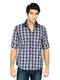

In [52]:
img = df.iloc[0]['image']
img

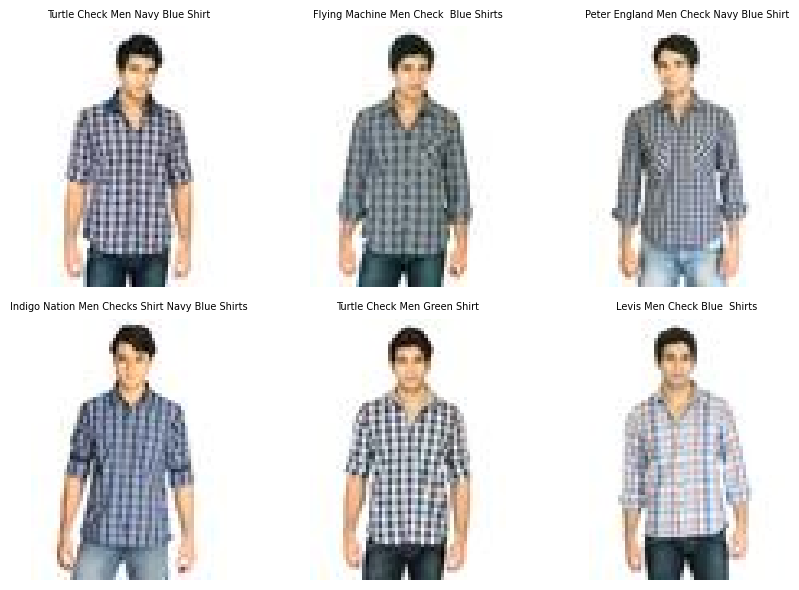

In [53]:
test_features = extract_features(df.iloc[0]).tolist()
results = get_results(test_features)
plot_results(results, df)

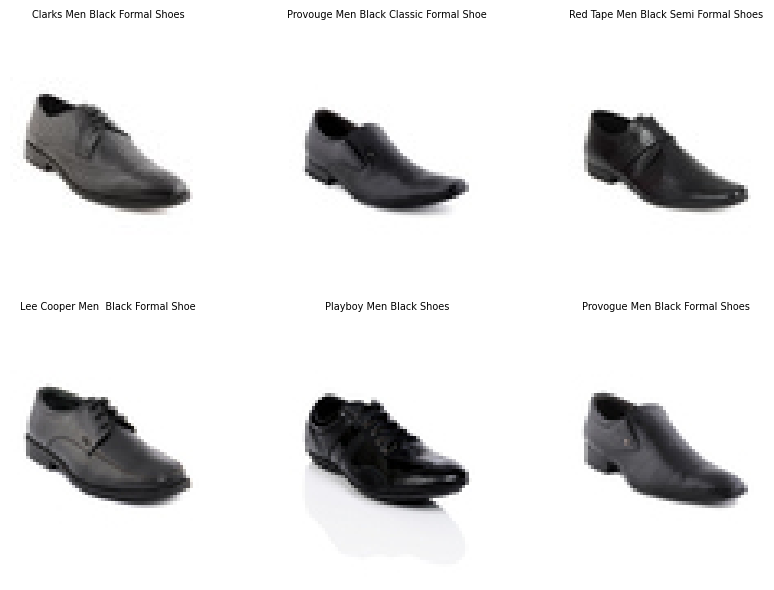

In [55]:
text = 'formal shoes for men'
test_features = extract_text_features(text)
results = get_results(test_features)
plot_results(results, df)